In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# 경고 무시
import warnings
warnings.filterwarnings('ignore')

# JSON 파일 경로
file_path = "result.json"

# 데이터 로드
with open(file_path, "r", encoding="utf-8") as f:
    data = json.load(f)

In [2]:
# 오류 유형 매핑 함수
def map_error_reason(reason):
    if reason.startswith("[ERROR] Timeout"):
        return "Timeout"
    elif reason.startswith("[ERROR] Runtime Error"):
        return "Runtime Error"
    elif reason == "Wrong Answer":
        return "Wrong Answer"
    else:
        return "Other Error"

# 하나의 실패 샘플에 대해 우선순위 기반으로 대표 오류 분류
def get_priority_error(reasons):
    reason_set = set(map(map_error_reason, reasons))
    if "Runtime Error" in reason_set:
        return "Runtime Error"
    elif "Timeout" in reason_set:
        return "Timeout"
    elif "Wrong Answer" in reason_set:
        return "Wrong Answer"
    else:
        return "Other Error"

In [3]:

# 통계 초기화
stats = defaultdict(lambda: {
    "total": 0,
    "pass": 0,
    "fail": 0,
    "Runtime Error": 0,
    "Wrong Answer": 0,
    "Timeout": 0,
    "Other Error": 0
})

# 통계 누적
for item in data:
    p = item["p_name"]
    stats[p]["total"] += 1

    if item["result"] == "pass":
        stats[p]["pass"] += 1
    else:
        stats[p]["fail"] += 1
        reasons = [f.get("reason", "") for f in item.get("failures", [])]
        major_error = get_priority_error(reasons)
        stats[p][major_error] += 1

# 비율 계산
records = []
for p_name, s in stats.items():
    total = s["total"]
    fail = s["fail"]
    if total == 0:
        continue
    records.append({
        "p_name": p_name,
        "total": total,
        "pass_rate": s["pass"] / total,
        "fail_rate": fail / total,
        "runtime_error_ratio_in_fail": s["Runtime Error"] / fail if fail else 0,
        "timeout_ratio_in_fail": s["Timeout"] / fail if fail else 0,
        "wrong_answer_ratio_in_fail": s["Wrong Answer"] / fail if fail else 0,
        "other_error_ratio_in_fail": s["Other Error"] / fail if fail else 0
    })

df_priority = pd.DataFrame(records)

# 정렬 및 저장
df_priority = df_priority.sort_values(by="pass_rate", ascending=True)
# df_priority.to_csv("per_problem_priority_error_ratios.csv", index=False)
# print("\n✅ 저장 완료: per_problem_priority_error_ratios.csv")

# 상위 10개 문제 출력
print("\n[우선순위 기반 오류 비율 상위 10개 문제 (pass_rate 낮은 순)]")
print(df_priority.head(10))


[우선순위 기반 오류 비율 상위 10개 문제 (pass_rate 낮은 순)]
     p_name  total  pass_rate  fail_rate  runtime_error_ratio_in_fail  \
410  p02664    658        0.0        1.0                     0.179331   
2    p02608   1077        0.0        1.0                     0.387187   
4    p03607    487        0.0        1.0                     0.139630   
390  p02606    404        0.0        1.0                     0.066832   
47   p03672    521        0.0        1.0                     0.120921   
52   p03573    130        0.0        1.0                     0.092308   
63   p03471   3246        0.0        1.0                     0.291128   
65   p03564    199        0.0        1.0                     0.020101   
18   p03360    518        0.0        1.0                     0.175676   
60   p02866   2532        0.0        1.0                     0.326619   

     timeout_ratio_in_fail  wrong_answer_ratio_in_fail  \
410               0.024316                    0.796353   
2                 0.043640          

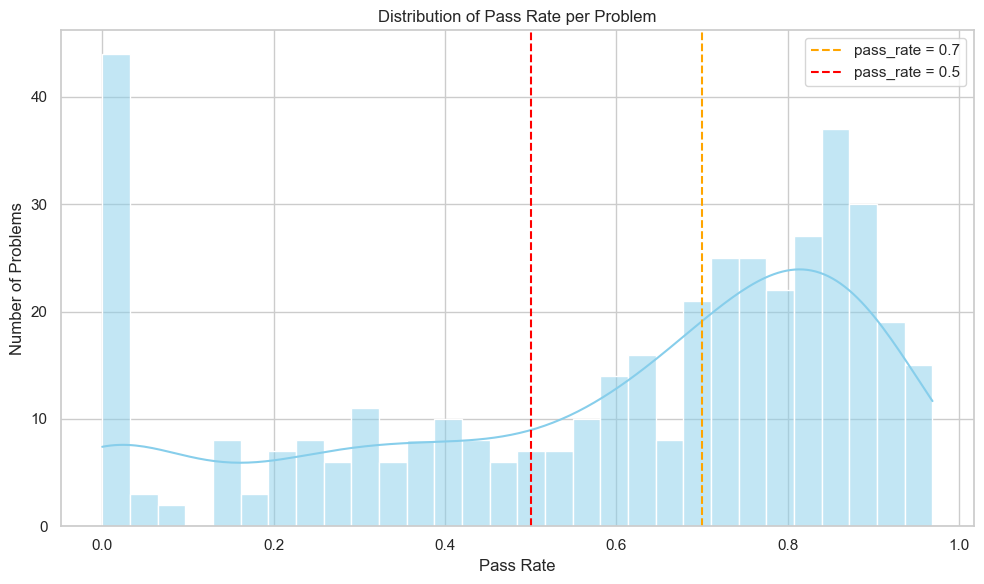

In [5]:
# pass_rate 분포 시각화
plt.figure(figsize=(10, 6))
sns.histplot(df_priority["pass_rate"], bins=30, kde=True, color="skyblue")

plt.title("Distribution of Pass Rate per Problem")
plt.xlabel("Pass Rate")
plt.ylabel("Number of Problems")
plt.axvline(0.7, color='orange', linestyle='--', label='pass_rate = 0.7')
plt.axvline(0.5, color='red', linestyle='--', label='pass_rate = 0.5')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("pass_rate_distribution.png")
plt.show()